In [1]:
import torch
import torch.nn as nn
import torch.utils
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
class FF(nn.Module):
    def __init__(self, dim1, dim2, dim3):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=dim1, out_features=dim2),
            nn.ReLU(),
            nn.Linear(in_features=dim2, out_features=dim3)
        )

    def forward(self, input):
        return self.main(input)

In [4]:
class VAE(nn.Module):
    def __init__(self, dim1, dim2, dim3):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(dim1, dim2)
        self.fc21 = nn.Linear(dim2, dim3)  # Mean
        self.fc22 = nn.Linear(dim2, dim3)  # Variance
        self.fc3 = nn.Linear(dim3, dim2)
        self.fc4 = nn.Linear(dim2, dim1)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [5]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [6]:
def train(data_loader, model, optimizer, epochs=20):
    model.to(device)  # GPU
    model.train()
    losses = []
    for epoch in range(epochs):
        for i, (x, _) in enumerate(data_loader):
            x = x.to(device)  # GPU
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(x)
            loss = loss_function(recon_batch, x, mu, logvar)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f"{epoch}/{i}: {loss.item()}")
    return model, losses

In [7]:
def plot_latent(data_loader, model, num_batches=100):
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(data_loader):
            x = x.to(device)
            mu, logvar = model.encode(x.view(-1, 28*28))
            z = model.reparameterize(mu, logvar)
            z = z.to('cpu').detach().numpy()
            plt.scatter(z[:, 0], z[:, 1], c=y, alpha=0.5)
            if i > num_batches:
                plt.colorbar()
                break

In [8]:
# Load MNIST dataset
transform_vae = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x, start_dim=-2))
])

data_vae = datasets.MNIST('./data', transform=transform_vae, download=True)

data_loader_vae = torch.utils.data.DataLoader(data_vae, batch_size=128, shuffle=True)

# Initialize VAE model
vae_model = VAE(dim1=28*28, dim2=512, dim3=2)

# Initialize optimizer
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)

# Train VAE model
trained_model, losses = train(data_loader_vae, vae_model, optimizer)

0/0: 70356.4453125
0/100: 22971.357421875
0/200: 24622.552734375
0/300: 22445.865234375
0/400: 22296.5625
1/0: 20464.72265625
1/100: 21809.037109375
1/200: 21431.994140625
1/300: 21254.833984375
1/400: 21779.546875
2/0: 21387.373046875
2/100: 21276.734375
2/200: 20110.12890625
2/300: 21398.140625
2/400: 20707.302734375
3/0: 21592.7421875
3/100: 21046.640625
3/200: 20264.572265625
3/300: 19423.96875
3/400: 19617.23828125
4/0: 19707.794921875
4/100: 18972.02734375
4/200: 20643.505859375
4/300: 19739.111328125
4/400: 19937.92578125
5/0: 20063.3515625
5/100: 19164.140625
5/200: 20531.248046875
5/300: 19921.740234375
5/400: 20861.57421875
6/0: 20888.978515625
6/100: 19110.056640625
6/200: 21142.1640625
6/300: 19729.19921875
6/400: 19772.6328125
7/0: 19973.59375
7/100: 19892.05078125
7/200: 20150.373046875
7/300: 19892.56640625
7/400: 20643.990234375
8/0: 19659.998046875
8/100: 18790.03125
8/200: 19421.208984375
8/300: 20269.70703125
8/400: 19049.267578125
9/0: 19162.0078125
9/100: 19113.115

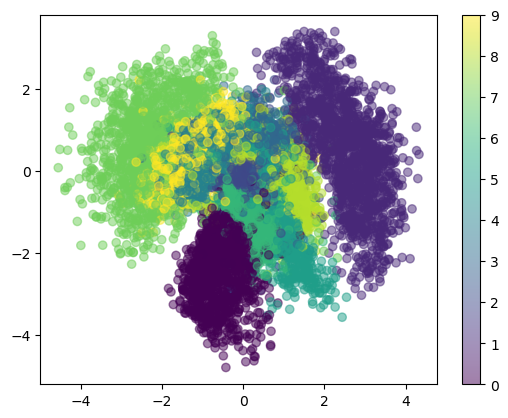

In [9]:
# Plot latent space
plot_latent(data_loader_vae, trained_model)
plt.show()

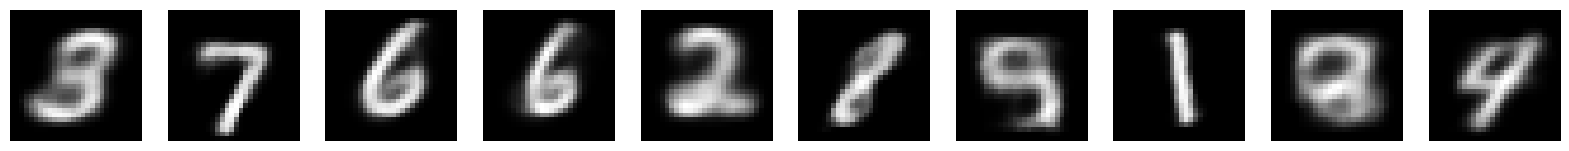

<Figure size 640x480 with 0 Axes>

In [10]:
def plot_generated_samples(model, num_samples=10):
    with torch.no_grad():
        z = torch.randn(num_samples, model.fc21.out_features).to(device)  # Sample from standard normal distribution
        generated_samples = model.decode(z).cpu().view(-1, 1, 28, 28)  # Pass through decoder
        generated_samples = generated_samples.numpy()

        fig, axs = plt.subplots(1, num_samples, figsize=(20, 2))
        for i, sample in enumerate(generated_samples):
            axs[i].imshow(sample[0], cmap='gray')
            axs[i].axis('off')
        plt.show()

# Plot generated samples
plot_generated_samples(trained_model)
plt.savefig('generated.pdf')